# package import 

In [93]:
import os
import cv2
import numpy as np
import torch
import random
import torch.nn as nn
from torchvision.ops import nms
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from model.centernet import CenterNet
from utils import pool_nms, inference_preprocess
from config import Config

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

%matplotlib inline

# model config

In [94]:
NUM_CLASSES = 80
DEPTH = 34
LOAD_FROM = 'ckpt/ckpt.pth'
LABEL_PATH = 'dataset/coco_classes.txt'
with open(LABEL_PATH, 'r') as f:
    LABELS = f.readlines()
LABELS = list(map(lambda x: x[:-1], LABELS))
COLOR_MAP = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in range(len(LABELS))]

# load model 

In [95]:
model = CenterNet(depth=DEPTH, num_classes=NUM_CLASSES)
if torch.cuda.is_available():
    model = model.cuda()
    model = nn.DataParallel(model)
model.load_state_dict(torch.load(LOAD_FROM))
model.eval()

pretrained model loading done!


DataParallel(
  (module): CenterNet(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

# generate x, y axis location

In [96]:
yv, xv = torch.meshgrid(torch.arange(0, 128), torch.arange(0, 128))
xv, yv = xv.flatten().float(), yv.flatten().float()
if torch.cuda.is_available():
    xv = xv.cuda()
    yv = yv.cuda()

In [97]:
print(xv)
print(yv)

tensor([  0.,   1.,   2.,  ..., 125., 126., 127.], device='cuda:0')
tensor([  0.,   0.,   0.,  ..., 127., 127., 127.], device='cuda:0')


# load image

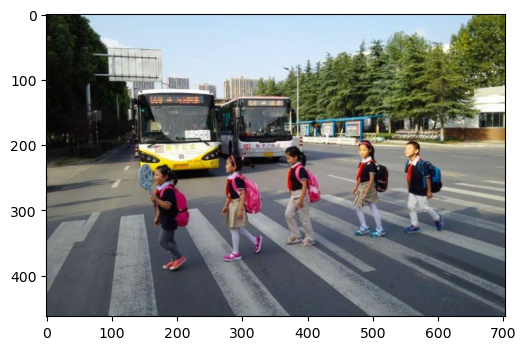

In [98]:
image_path = 'dataset/imgs/img3.jpg'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(dpi=100)
plt.imshow(img)

# preprocess

In [99]:
img_h, img_w, _ = img.shape
inputs = inference_preprocess(img)
if torch.cuda.is_available():
    inputs = inputs.cuda()

# inference

In [100]:
heatmap, wh, offset = model(inputs)

In [101]:
print('heatmap shape: ', heatmap.shape)
print('wh shape: ', wh.shape)
print('offset shape', offset.shape)

heatmap shape:  torch.Size([1, 80, 128, 128])
wh shape:  torch.Size([1, 2, 128, 128])
offset shape torch.Size([1, 2, 128, 128])


# heatmap visualization

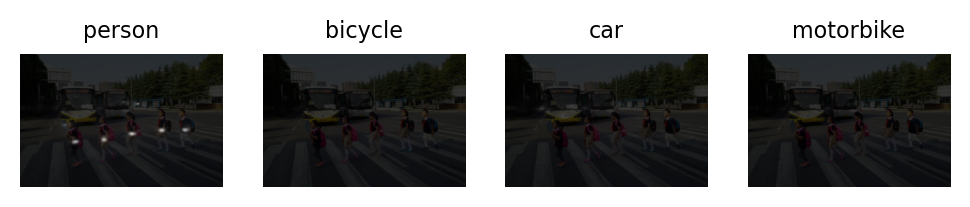

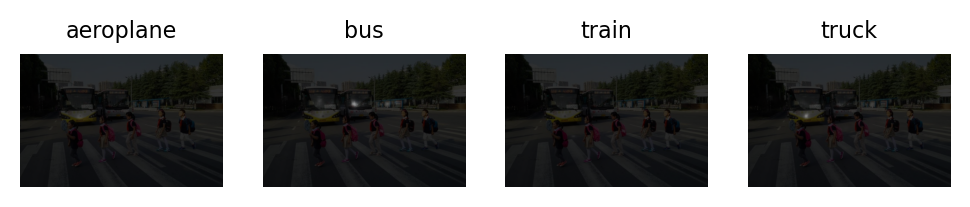

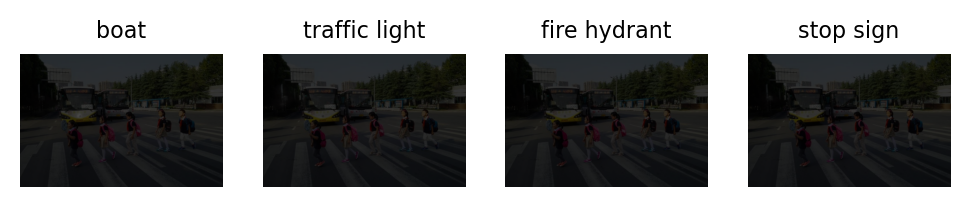

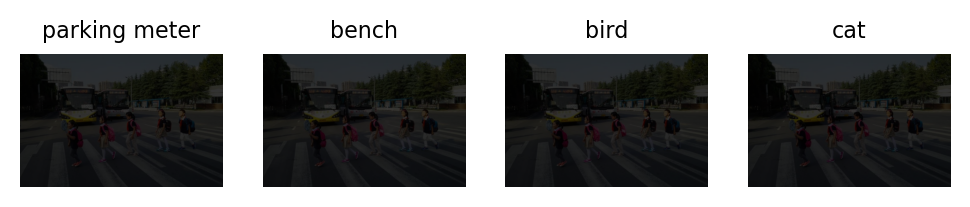

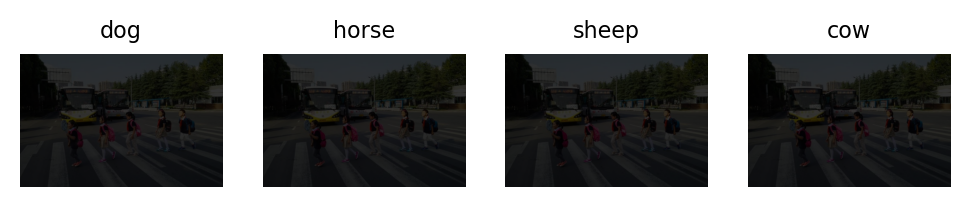

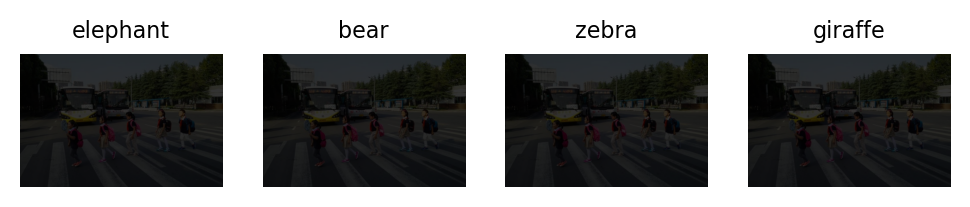

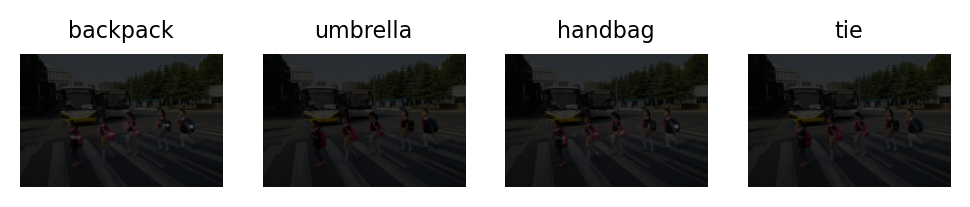

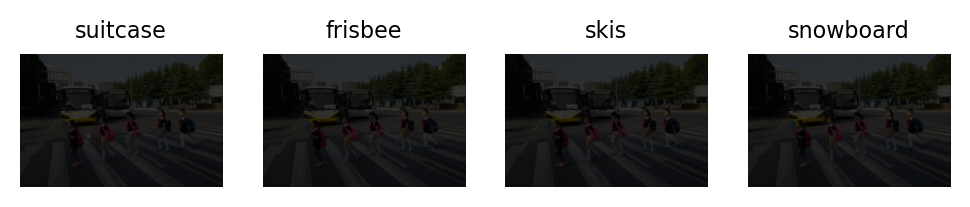

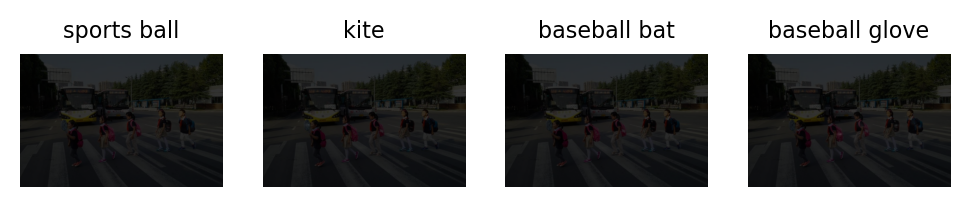

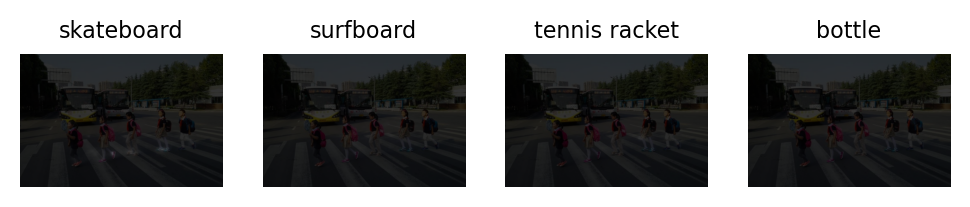

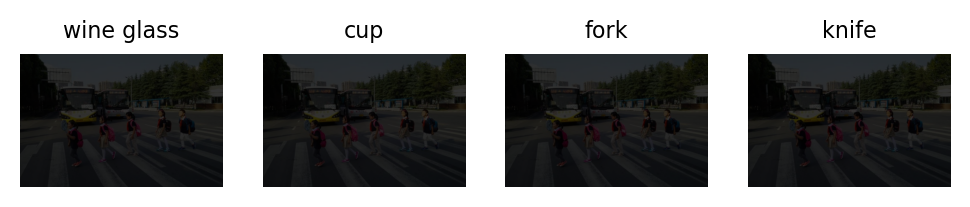

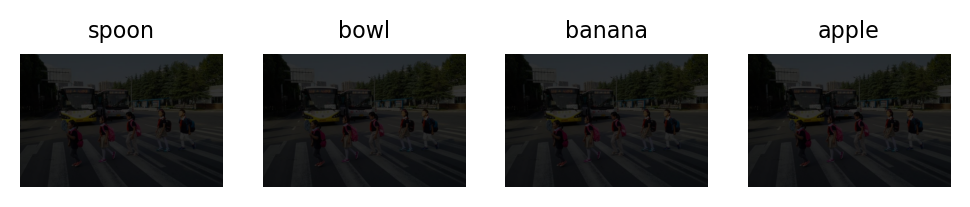

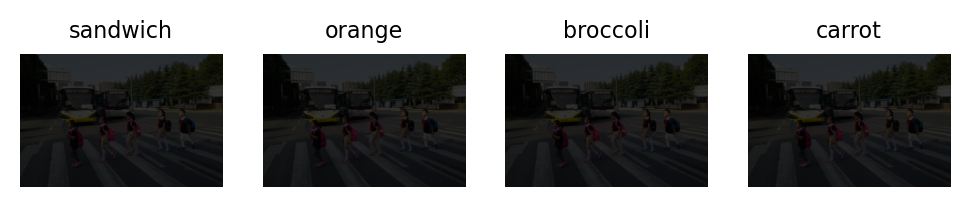

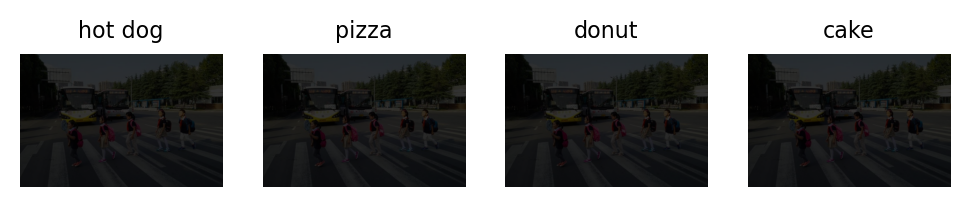

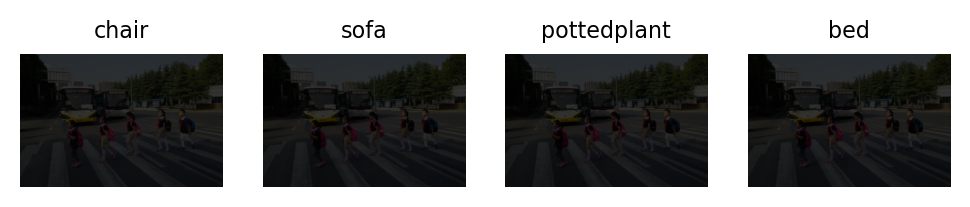

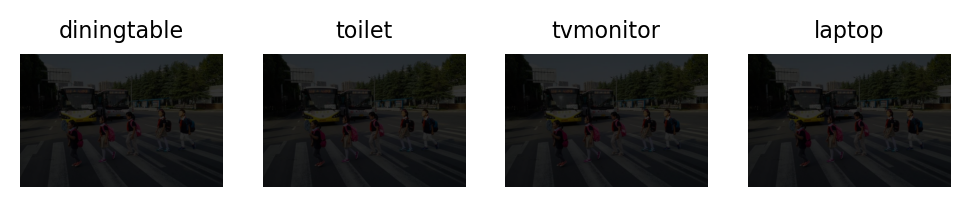

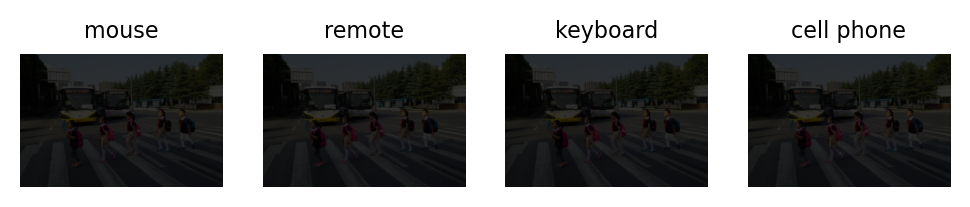

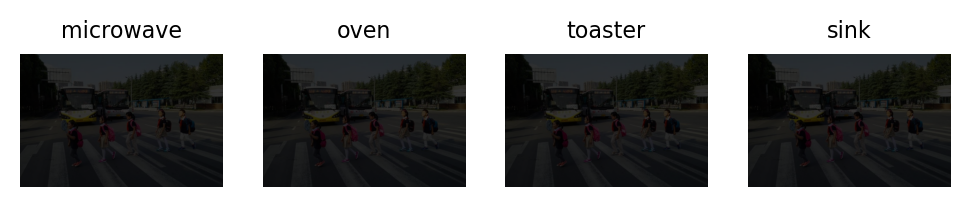

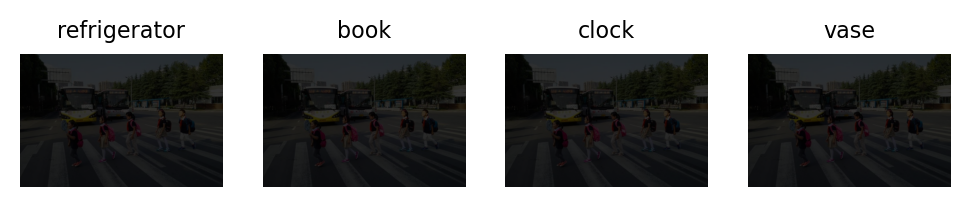

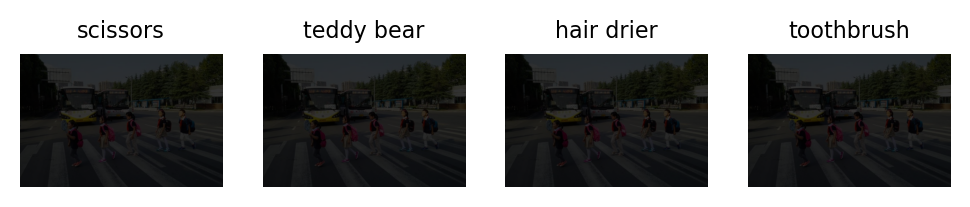

In [102]:
numpy_heatmap = heatmap[0].permute(1, 2, 0).cpu().detach().numpy()
num_classes = numpy_heatmap.shape[-1]
i = 0
COLS = 4
ROWS = np.ceil(num_classes / COLS)

while i < num_classes:
    plt.figure(dpi=200)
    for _ in range(COLS):
        curr_heatmap = numpy_heatmap[:, :, i]
        curr_heatmap = cv2.resize(curr_heatmap, (img_w, img_h))
        curr_heatmap = np.array(curr_heatmap * 255, dtype=np.uint8)
        curr_heatmap = cv2.cvtColor(curr_heatmap, cv2.COLOR_GRAY2BGR)
        merged_img = cv2.addWeighted(curr_heatmap, 0.8, img, 0.2, 0)
        
        plt.subplot(1, COLS, (i % COLS + 1))
        plt.imshow(merged_img)
        plt.title(LABELS[i], fontdict={'size': 8})
        plt.axis('off')
        i += 1

# postprocess

In [103]:
# 1. pool nms
# on location (x, y)
# if hm[x, y] > (hm[x-1, y], hm[x-1,y-1], hm[x-1][y+1], hm[x+1, y], hm[x+1, y-1], hm[x+1, y+1], hm[x, y-1], hm[x, y+1])
# then location (x, y) is a keypoint
# we apply this with 3 * 3 max pooling
heatmap = pool_nms(heatmap)

# cause batch == 1
heatmap = heatmap[0]
wh = wh[0]
offset = offset[0]

# permute axis
heatmap = heatmap.permute(1, 2, 0)
wh = wh.permute(1, 2, 0)
offset = offset.permute(1, 2, 0)

In [104]:
print('heatmap shape: ', heatmap.shape)
print('wh shape: ', wh.shape)
print('offset shape', offset.shape)

heatmap shape:  torch.Size([128, 128, 80])
wh shape:  torch.Size([128, 128, 2])
offset shape torch.Size([128, 128, 2])


# flatten all maps

In [105]:
heatmap = heatmap.reshape(-1, num_classes)
wh = wh.reshape(-1, 2)
offset = offset.reshape(-1, 2)

# select keypoints

In [106]:
score_thresh = 0.3

class_confs, class_preds = torch.max(heatmap, dim=-1)
mask = (class_confs >= score_thresh)
wh_preds = wh[mask]
offset_preds = offset[mask]
classes_preds = class_preds[mask]
scores_preds = class_confs[mask]

In [107]:
# map wh to featuremap size
wh_preds *= 128

In [108]:
# add center point offset
half_w, half_h = wh_preds[..., 0] / 2, wh_preds[..., 1] / 2
X = xv[mask]
Y = yv[mask]
X = X + offset_preds[:, 0]
Y = Y + offset_preds[:, 1]

In [109]:
# get detected boxes
boxes = torch.stack([X - half_w, Y - half_h, X + half_w, Y + half_h], dim=1)  # [x1, y1, x2, y2]
boxes /= 128  # map pred to [0, 1]

boxes[:, [0, 2]] *= img_w
boxes[:, [1, 3]] *= img_h

boxes[:, [0, 2]] = torch.clamp(boxes[:, [0, 2]], 0, img_w - 1)
boxes[:, [1, 3]] = torch.clamp(boxes[:, [1, 3]], 0, img_h - 1)

# nms

In [110]:
nms_thresh = 0.3
keep = nms(boxes, scores_preds, iou_threshold=nms_thresh)

boxes = boxes[keep]
classes = classes_preds[keep]
scores = scores_preds[keep]

# detach tensor from gpu to cpu

In [111]:
if torch.cuda.is_available():
    boxes = boxes.cpu()
    classes = classes.cpu()
    scores = scores.cpu()

boxes = boxes.detach().numpy()
classes = classes.detach().numpy()
scores = scores.detach().numpy()

# imshow

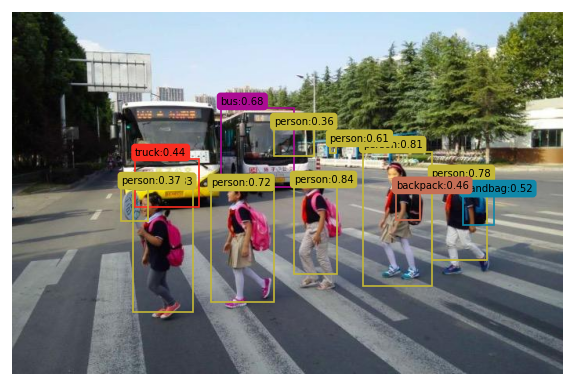

In [112]:
# imshow
plt.figure(dpi=120)
plt.imshow(img)
for i in range(len(boxes)):
    x1, y1, x2, y2 = boxes[i]
    w, h = x2 - x1, y2 - y1
    catId = classes[i]
    className = LABELS[catId]
    score = scores[i]
    plt.gca().add_patch(patches.Rectangle((x1, y1), w, h, color=COLOR_MAP[catId], fill=False))
    msg = "{}:{:.2f}".format(className, score)
    plt.text(x1, y1-5, msg,
             bbox=dict(facecolor=COLOR_MAP[catId], edgecolor=COLOR_MAP[catId], boxstyle='round'),
             fontdict={'size': 6})

plt.axis('off')

plt.show()